<a href="https://colab.research.google.com/github/mr-nastik/UrbanSound8k/blob/main/UrbanSound8k_melspectrum_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH='/content/gdrive/My Drive/urbansound8k/'

In [ ]:
!pip install soundfile
!pip install livelossplot

In [ ]:
#for model creation
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from livelossplot import PlotLossesKeras

#for data handaling
import os
from tqdm.auto import tqdm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#for calc accuaracy and spliting the data
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline

#for sound
import librosa
import librosa.display
import glob 
import skimage
import soundfile as sf
from scipy.io.wavfile import read


import warnings
warnings.filterwarnings('ignore')

In [ ]:
df=pd.read_csv(PATH+'UrbanSound8K.csv')
df['salience']=df['salience'].replace(1,0)
df['salience']=df['salience'].replace(2,1)
print("shape of train.csv: ",df.shape)

shape of train.csv:  (8732, 8)


In [ ]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,0,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,0,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,0,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,0,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,0,5,2,children_playing


In [ ]:
df.tail()

,slice_file_name,fsID,start,end,salience,fold,classID,class
8727,99812-1-2-0.wav,99812,159.522205,163.522205,1,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,1,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,1,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,1,7,1,car_horn
8731,99812-1-6-0.wav,99812,332.289233,334.821332,1,7,1,car_horn


In [ ]:
def plot_count(feature, title, df, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:30], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:d}'.format(height),
                ha="center") 
    plt.savefig('freq of '+feature+'.png', dpi=300, bbox_inches='tight')
    plt.show()

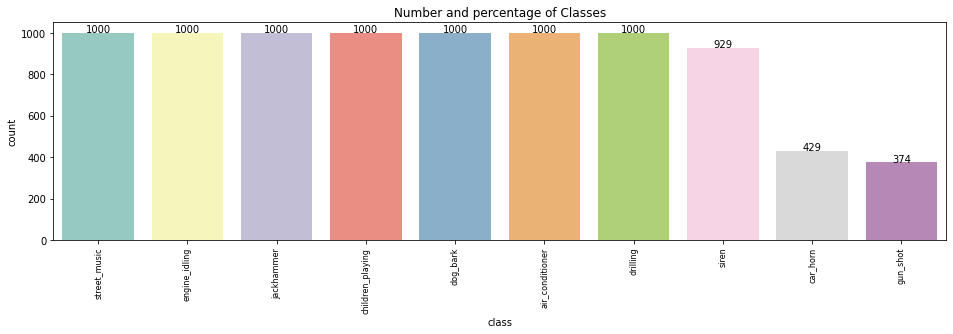

In [ ]:
plot_count('class', 'Classes', df, size=4)

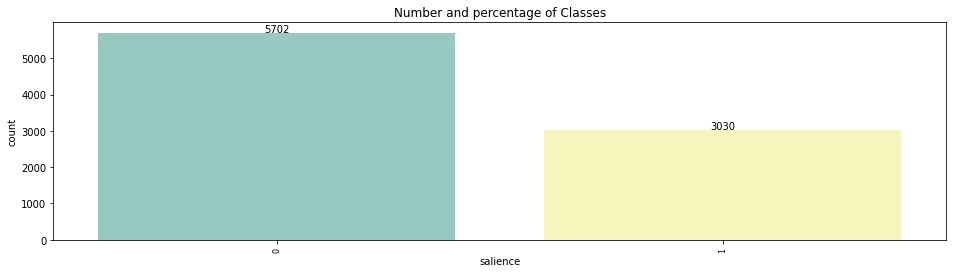

In [ ]:
plot_count('salience', 'Classes', df, size=4)

In [ ]:
foreground=df[df.salience==0]
background=df[df.salience==1]

In [ ]:
print(foreground.shape,background.shape)

(5702, 8) (3030, 8)


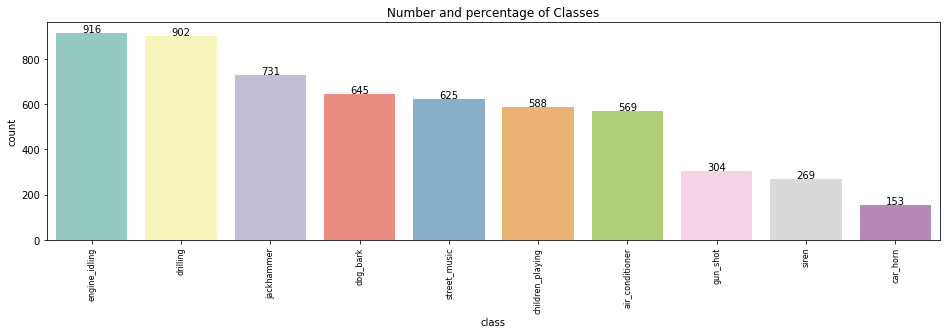

In [ ]:
plot_count('class', 'Classes', foreground, size=4)

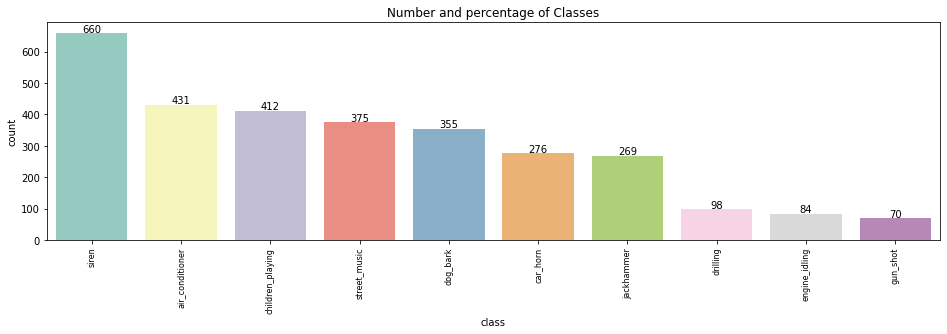

In [ ]:
plot_count('class', 'Classes', background, size=4)

In [ ]:
X=[]
Y=[]
for i in tqdm(range(8732)):
    data,sr=librosa.load(PATH+'fold'+str(df['fold'][i])+'/'+df['slice_file_name'][i],res_type='kaiser_fast',mono=True,duration=4)
    j=0
    while(len(data)<4*sr):
        data=np.append(data,data[j])
        j+=1
    data=librosa.feature.mfcc(y=data,sr=sr,n_mfcc=60)
    X.append(data)
    Y.append(df['classID'][i])

KeyboardInterrupt: ignored

In [ ]:
X=np.asarray(X)
Y=np.array(Y)
Y=keras.utils.to_categorical(Y)

In [ ]:
np.save(PATH+'mfcc_CNN_60_ks_4s_X.npy',X)
np.save(PATH+'mfcc_CNN_60_ks_4s_Y.npy',Y)

In [ ]:
X0=np.load(PATH+'melspectrogram_CNN_128_ks_X.npy')
Y0=np.load(PATH+'melspectrogram_CNN_128_ks_Y.npy')
#Y_Salience=np.load(PATH+'mfcc_CNN_60_ks_4s_Y_Salience.npy')

In [ ]:
X0.shape

(8732, 128, 200)

In [ ]:
X0=X0.reshape(-1,128,200,1)
x_train, x_test, y_train, y_test = train_test_split(X0, Y0, test_size=0.3, random_state=171210013)

In [ ]:
print(x_train.shape,
y_train.shape,
x_val.shape,
y_val.shape)

(6112, 128, 200, 1) (6112, 10) (1747, 128, 200, 1) (1747, 10)


In [ ]:
inputs= Input(shape=(128,200,1))
model=Conv2D(filters=32,kernel_size=(5,5),padding='SAME',activation='relu')(inputs)
model=BatchNormalization(momentum=0.2)(model)
model=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=AveragePooling2D(pool_size=(2,2))(model)

model=Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu')(model)

model=AveragePooling2D(pool_size=(2,2))(model)

model=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=AveragePooling2D(pool_size=(2,2))(model)

model=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=BatchNormalization(momentum=0.2)(model)
model=AveragePooling2D(pool_size=(2,2))(model)

model=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=AveragePooling2D(pool_size=(2,2))(model)

model=Flatten()(model)
model=Dense(512,activation='relu')(model)
model=BatchNormalization(momentum=0.2)(model)
model=Dense(64,activation='relu')(model)
model=BatchNormalization(momentum=0.2)(model)

output=Dense(10,activation='softmax',name='output')(model)

model=Model(inputs=inputs,outputs=[output])

In [ ]:
model.summary()
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
mcp_save = ModelCheckpoint(PATH+'model_melspectrum.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-5, mode='min')

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 200, 1)]     0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 128, 200, 32)      832       
_________________________________________________________________
batch_normalization_24 (Batc (None, 128, 200, 32)      128       
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 128, 200, 32)      9248      
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 128, 200, 32)      9248      
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 128, 200, 32)      9248      
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 128, 200, 32)      9248

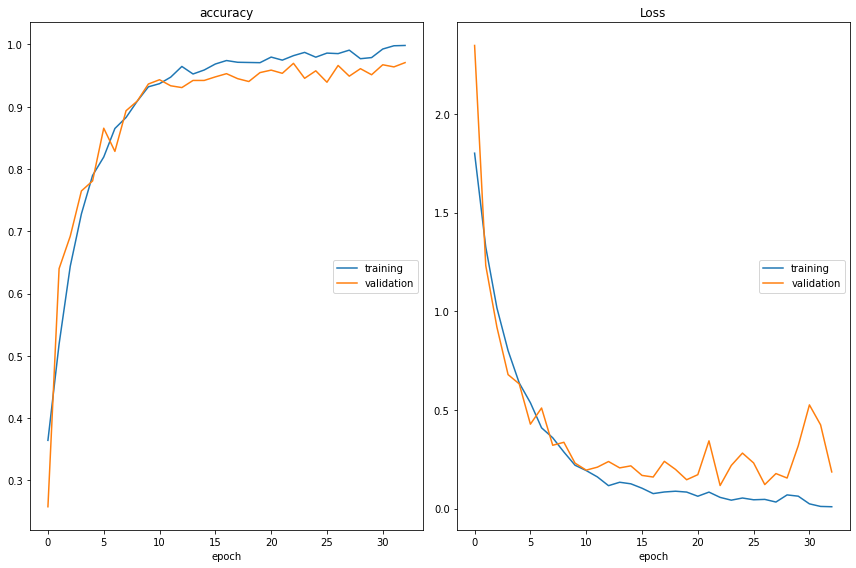

accuracy
	training         	 (min:    0.364, max:    0.998, cur:    0.998)
	validation       	 (min:    0.258, max:    0.971, cur:    0.971)
Loss
	training         	 (min:    0.010, max:    1.801, cur:    0.010)
	validation       	 (min:    0.117, max:    2.347, cur:    0.186)
Epoch 00033: early stopping


In [ ]:
model.fit(x_train, y_train,
          epochs=200,
          callbacks=[PlotLossesKeras(), earlyStopping, mcp_save, reduce_lr_loss],
          verbose=1,
          validation_data=(x_val, y_val))

In [ ]:
score = model.evaluate(x_val, y_val)
print(score)

55/55 [==============================] - 2s 33ms/step - loss: 0.1860 - accuracy: 0.9708
[0.18601875007152557, 0.9708070755004883]


In [ ]:
model.load_weights(PATH+'model_melspectrum.hdf5')
score = model.evaluate(x_val, y_val)
print(score)

55/55 [==============================] - 2s 34ms/step - loss: 0.1172 - accuracy: 0.9697
[0.11717209964990616, 0.9696622490882874]


In [ ]:
model.evaluate(X0,Y0)

273/273 [==============================] - 10s 36ms/step - loss: 0.1250 - accuracy: 0.9714


[0.12502053380012512, 0.9713696837425232]